In [1]:
##This block is only for access of files using google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import cv2;
import matplotlib.pyplot as plt

import numpy as np;
from random import shuffle;
import cv2;
from random import shuffle;
from tqdm import tqdm;
import tensorflow;
from tensorflow.keras import layers;
from tensorflow.keras import Model;
from tensorflow.keras.optimizers import SGD;


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
train_Data_File = drive.CreateFile({'id': '11UzJtoYiSvlIfUmXB__BnAcAJKqosiV8'});
train_Data_File.GetContentFile('Nerve_Segmentation_Data.zip');

In [2]:
!unzip 'Nerve_Segmentation_Data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: 34_114_mask.tif         
  inflating: 34_115.tif              
  inflating: 34_115_mask.tif         
  inflating: 34_116.tif              
  inflating: 34_116_mask.tif         
  inflating: 34_117.tif              
  inflating: 34_117_mask.tif         
  inflating: 34_118.tif              
  inflating: 34_118_mask.tif         
  inflating: 34_119.tif              
  inflating: 34_119_mask.tif         
  inflating: 34_11_mask.tif          
  inflating: 34_12.tif               
  inflating: 34_12_mask.tif          
  inflating: 34_13.tif               
  inflating: 34_13_mask.tif          
  inflating: 34_14.tif               
  inflating: 34_14_mask.tif          
  inflating: 34_15.tif               
  inflating: 34_15_mask.tif          
  inflating: 34_16.tif               
  inflating: 34_16_mask.tif          
  inflating: 34_17.tif               
  inflating: 34_17_mask.tif          
  inflating: 34_18.tif               

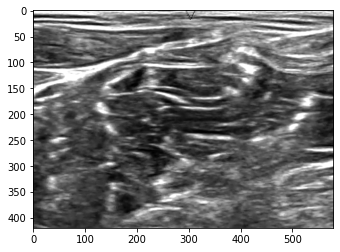

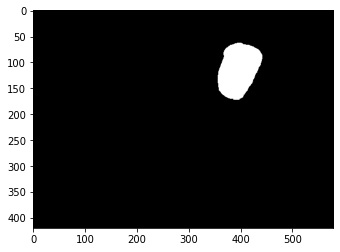

In [3]:
from PIL import Image
im = np.array(Image.open("34_31.tif"))
im_mask = np.array(Image.open("34_31_mask.tif"))
plt.imshow(im, cmap='gray')
plt.show()
plt.imshow(im_mask, cmap='gray')

In [4]:
#Resizing the images and masks and normalizing

import glob
from tqdm import tqdm;
ImSize = 140;
image_Array = np.zeros((len(glob.glob("*_mask.tif")),ImSize, ImSize))
mask_Array = np.zeros((len(glob.glob("*_mask.tif")),ImSize, ImSize))
file_Names = set();
count = 0;
for file in tqdm(glob.glob("*_mask.tif")):
  f_Name = file.split("_mask.tif")[0]
  file_Names.add(f_Name)
  I = np.array(Image.open(f_Name+".tif").resize((ImSize,ImSize)));
  image_Array[count,:,:] = I/255;
  I = np.array(Image.open(f_Name+"_mask.tif").resize((ImSize,ImSize)));
  mask_Array[count,:,:] = I/255;
  count = count+1;

100%|██████████| 5635/5635 [00:44<00:00, 127.33it/s]


In [6]:
image_Array.shape

(5635, 140, 140)

In [7]:
mask_Array.shape

(5635, 140, 140)

**Question:**


Accurately identifying nerve structures in ultrasound images is a critical step in effectively inserting a patient’s pain management catheter. In this you are challenged to build a model that can identify nerve structures in a dataset of ultrasound images of the neck. Doing so would improve catheter placement and contribute to a more pain free future. 

The task in this competition is to segment a collection of nerves called the Brachial Plexus (BP) in ultrasound images. You are provided with a large training set of images where the nerve has been manually annotated by humans. Annotators were trained by experts and instructed to annotate images where they felt confident about the existence of the BP landmark.

Make an autoencoder model to perform automatic segmentation of the BP in ultrasound images.

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(ImSize, ImSize, 1))  
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)


x = UpSampling2D((2, 2))(encoded)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()
encoder.summary()
print(encoded.shape)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 140, 140, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 140, 140, 16)      160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 70, 70, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 70, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 35, 35, 1)         73        
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 70, 70, 1)         0   

In [9]:
image_Array.shape
mask_Array.shape

(5635, 140, 140)

Training Autoencoder

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_Array, mask_Array, test_size=0.2, random_state=42)

In [11]:
##We try to identify the mask as output from the input ultrasound images
autoencoder.fit( X_train,y_train,
                epochs=50,
                batch_size=1024,
                shuffle=True,
                validation_data=(X_test, y_test))

Epoch 1/50
5/5 [==============================] - 44s 2s/step - loss: 0.6915 - val_loss: 0.6847
Epoch 2/50
5/5 [==============================] - 3s 619ms/step - loss: 0.6824 - val_loss: 0.6732
Epoch 3/50
5/5 [==============================] - 3s 629ms/step - loss: 0.6702 - val_loss: 0.6580
Epoch 4/50
5/5 [==============================] - 3s 627ms/step - loss: 0.6541 - val_loss: 0.6383
Epoch 5/50
5/5 [==============================] - 3s 632ms/step - loss: 0.6332 - val_loss: 0.6131
Epoch 6/50
5/5 [==============================] - 3s 636ms/step - loss: 0.6066 - val_loss: 0.5813
Epoch 7/50
5/5 [==============================] - 3s 641ms/step - loss: 0.5732 - val_loss: 0.5419
Epoch 8/50
5/5 [==============================] - 3s 644ms/step - loss: 0.5322 - val_loss: 0.4948
Epoch 9/50
5/5 [==============================] - 3s 640ms/step - loss: 0.4836 - val_loss: 0.4406
Epoch 10/50
5/5 [==============================] - 3s 633ms/step - loss: 0.4280 - val_loss: 0.3810
Epoch 11/50
5/5 [====

Visaualizing output

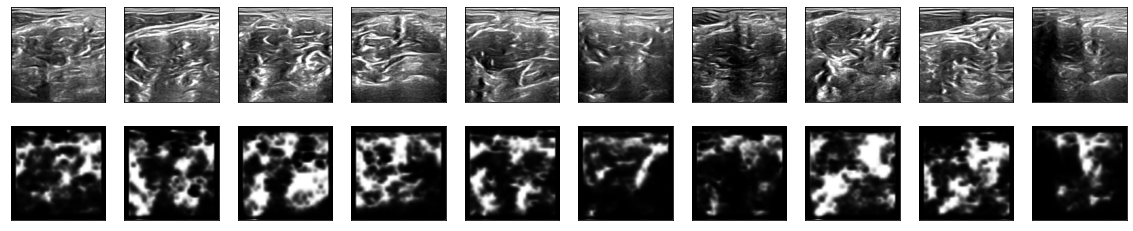

In [12]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(decoded_imgs[i].reshape(140, 140))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
X_test.shape

(1127, 140, 140)